# 1. Data preprocessing

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [88]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('dataset/train', transform=transform)
test_dataset = datasets.ImageFolder('dataset_demo', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

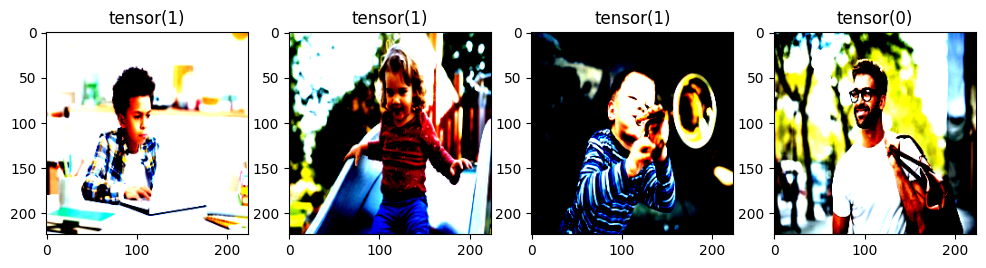

In [89]:
import numpy as np
from matplotlib import pyplot as plt
batch = next(iter(train_loader))
# clip the pixel values to be between 0 and 1
batch[0] = torch.clamp(batch[0], 0, 1)
# print 4 images
fig, ax = plt.subplots(1, 4, figsize=(12, 12))
for idx, image in enumerate(batch[0][:4]):
    ax[idx].imshow(image.permute(1, 2, 0))
    ax[idx].title.set_text(batch[1][idx])

# 2. Build model

In [90]:
from torchvision.models import mobilenet_v2
from torchvision.models import MobileNet_V2_Weights
from torchvision import models

In [91]:
model = models.mobilenet_v2(weights = MobileNet_V2_Weights.DEFAULT) 
model.classifier[1] = nn.Linear(model.last_channel, 2)  # Assuming 2 classes: adults and children

# 3. Train

In [92]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [93]:
losses = []  # Store the loss for each epoch

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    

AttributeError: module 'numpy' has no attribute 'long'

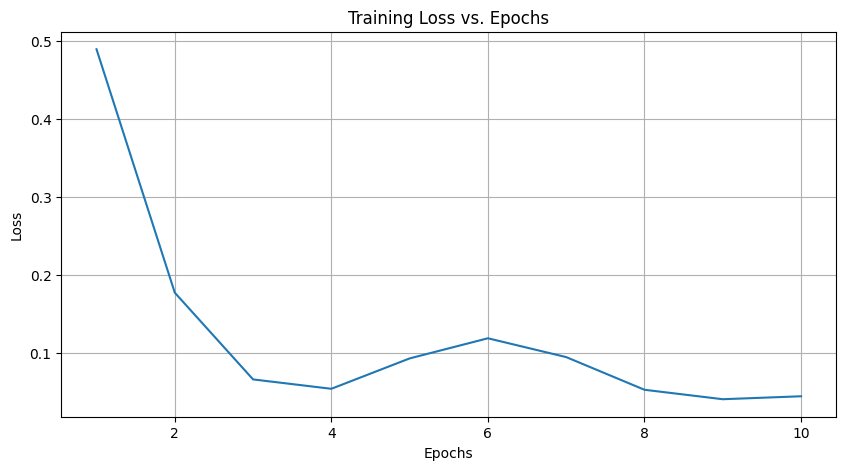

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses)
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 4. Evaluation

In [ ]:
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
correct = 0
total = 0

In [ ]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test dataset: {accuracy:.2f}%")

Accuracy on the test dataset: 81.67%


In [ ]:
# model complexity (number of parameters)
def profile_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params
params = profile_params(model)
print(f"Parameters: {params}")

Parameters: (2226434, 2226434)


In [ ]:
# computation complexity (number of FLOPs)
from thop import profile
from thop import clever_format

input = torch.randn(1, 3, 224, 224)
flops, params = profile(model, inputs=(input, ))
flops, params = clever_format([flops, params], "%.3f")
print(f"FLOPs: {flops}, Params: {params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


c:\Python36\Lib\site-packages\torchstat\model_hook.py:65: FutureWarning: In the future `np.long` will be defined as the corresponding NumPy scalar.
  np.array([parameter_quantity], dtype=np.long))


AttributeError: module 'numpy' has no attribute 'long'